# Control and Learning

(c) Jean Walrand, September 2021

This chapter explains some concepts and methods for the control of systems and how learning is used when the knowledge of the system is incomplete.

* We start with the control of the motion of a **marble on a board**.  The system is deterministic and the model is known precisely. For this system, we consider a **parametric controller** and we use a **brute-force** method to find good parameters. We comment on the **complexity** of designing the controller with this approach.

* We then explore the control of the motion of a **marble on a plate**. This is a two-dimensional version of the previous problem. We note that **domain knowledge** is important to simplify the design problem.

* We then use a parametric controller with the brute-force method to design the control of the **service rate of a queuing system**. This is a **stochastic system** and we observe that many simulation runs are needed to evaluate the average performance of the system.  This large number of simulation runs makes the brute-force method impractical for many systems.

* To illustrate optimal control techniques, we introduce a **cache replacement** optimization problem.  

* We explain the **dynamic programming** approach and derive the **dynamic programming equations** for the cache replacement problem.

* To solve the dynamic programming equations, we develop the **value iteration algorithm**.

* As an alternate approach, we explain the **policy iteration** algorithm.

* When the system model is not known, one can use **reinforcement learning** methods.  We start with **Q-Learning** that we develop as an approximation of value iteration.

* We then explain **policy iteration with learning**.

* Finally, we discuss a **bandit problem** and present the **Thompson sampling** algorithm. The main point in this example is the tradeoff between exploration and exploitation.


In [4]:
# First, we load ncessearcy libraries

from IPython.core.display import HTML
from IPython.display import Javascript
#from toggle_cell import toggle_code as hide_code
import numpy as np
import math
import matplotlib
import scipy
from scipy.stats import norm
from scipy.stats import binom
import pandas as pd
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
matplotlib.rcParams.update(params)
from matplotlib import pyplot as plt
import random
from ipywidgets import *
import pandas as pd

print('Libraries loaded successfully')

Libraries loaded successfully


# Marble on a board

We explore the **parametric control** of a marble on a board, as illustrated below.  The goal of the controller is to bring the marble to the center of the board by adjusting the angle $\alpha$ of the board. The observations are the position $x$ and velocity $\dot x$ of the marble. 

![title](Figures/marble1.pdf)

Our parametric controller is $\alpha = ax + b \dot x$.  The parameters are $a$ and $b$. Newton's law **force = mass $\times$ acceleration** implies that $\ddot x = - g  \sin(\alpha)$ where $g = 9.81m/s^2$.

To measure how good the controller is at bringing the marble to the center of the board, we use the cost $C$ defined by

$$C(a, b) = \int_0^\infty x^2(t) dt.$$

This cost is small if the marble goes quickly close to the center of the board where $x = 0$.

## Simulation

In the cell below, we simulate the motion of the marble.  The sliders allow you to change the initial conditions $x$ and $\dot x = v$ as well as the parameters $a$ and $b$. The simulation uses the following discrete-time approximation where one time step is $0.1$ second: 

$$x[n+1] = x[n] + 0.1 v[n]; v[n+1] = v[n] - 0.1 \times 9.81 \times \sin(ax[n] + bv[n])$$

where $v[n] = \dot x[n]$.  This approximation assumes that the velocity is constant during intervals of $0.1$ second instead of changing continuously.  The cost is then approximated by

$$C(a, b) = \sum_{n=0}^{N-1} x^2[n]$$

where $N = 10T$ is a chosen number of simulation steps that corresponds to $T$ seconds.

In [5]:
def dummy(ad,bd,xd,vd,Td):
    global a,b,x,v,T
    a,b,x,v,T = float(ad),float(bd),float(xd),float(vd),int(Td)
    
ad = widgets.Dropdown(options=['0', '0.05', '0.1','0.15','0.2','0.25','0.3','0.35','0.4'],value='0.2',description='a',disabled=False)
bd = widgets.Dropdown(options=['0', '0.05', '0.1','0.15','0.2','0.25','0.3','0.35','0.4'],value='0.1',description='b',disabled=False)
xd = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='x',disabled=False)
vd = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='v',disabled=False)
Td = widgets.Dropdown(options=['5', '10', '20','30','50','100','150','200','300','400','500'],value='100',description='v',disabled=False)
z = widgets.interactive(dummy, ad = ad, bd = bd, xd = xd,vd = vd, Td = Td) 
display(z)

interactive(children=(Dropdown(description='a', index=4, options=('0', '0.05', '0.1', '0.15', '0.2', '0.25', '…

We roll the ball with selected parameters a and b initial conditions x and v


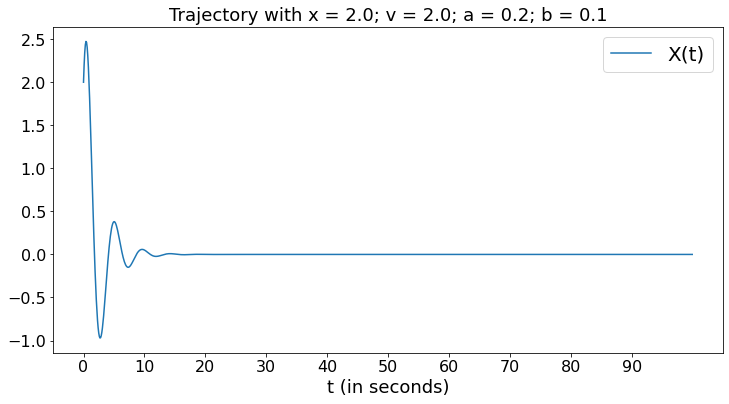

If you want to try other parameters, 
 go back to widgets above, select, and rerun this cell


In [6]:
##### ball on incline - controller based on position and velocity [slide 8]
matplotlib.rcParams.update(params)
print('We roll the ball with selected parameters a and b initial conditions x and v')
        
def rollBall6(a,b,x,v,T):
    epsilon = 0.1 # time step, in seconds
    N = round(T/epsilon)
    M = round(1/epsilon)
    F = round(T/10)
    G = round(N/10)
    X = np.zeros(N)
    V = np.zeros(N)
    C = 0
    m = 0
    X[0] = x
    V[0] = v
    for n in range(N-1):
        X[n+1] = X[n] + epsilon*V[n]
        alpha = max(- 1, min(1,a*X[n] + b*V[n] ))
        V[n+1] = V[n] - epsilon*9.81*np.sin(alpha)
    plt.plot(X, label ='X(t)')
    plt.xticks(np.arange(0,N,G),np.arange(0,T,F))
    plt.xlabel('t (in seconds)')
    plt.legend()
    plt.title('Trajectory with x = ' + str(x) +'; v = '+str(v) + '; a = ' + str(a)+'; b = '+str(b))
    plt.show()

rollBall6(a,b,x,v,T)
print('If you want to try other parameters, \n go back to widgets above, select, and rerun this cell')  

## Optimizing $a$ and $b$

To find good values of the parameters $a$ and $b$ we use a **brute-force** method.  We simulate the motion of the marble for fixed initial conditions $x$ and $v$ and for a discrete set of possible parameters.  Specifically, $a$ and $b$ take values in the set 

$$\{-5, -5 + 0.1, - 5 + 0.2, \ldots, 5 - 0.2, 5 - 0.1, 5\}.$$  

Thus, there are $101^2$ different pairs $(a, b)$ of parameter values and for each pair, we simulate the motion of the ball for $100$ steps.  For each simulation run, we keep track of the cost $C(a, b)$.  We then find the values of $a$ and $b$ that result in the minimum cost.

Note that to guarantee that the parameters work well for many different initial conditions we should also simulate for a range of such initial conditions.  For simplicity, we do not and hope that if the controller works well for our chosen initial conditions $x = 2$ and $v = 1$, it will work well for others.


In [7]:
##### ball on incline - controller based on position and velocity [slide 8]
matplotlib.rcParams.update(params)

print('We find the best values of a and b when x = 2 and v = 1')
print('The algorithm is running. Please wait ....')

def costBall(a,b,x,v,N):
    X = np.zeros(N)
    V = np.zeros(N)
    C = 0
    X[0] = x
    V[0] = v
    for n in range(N-1):
        X[n+1] = X[n] + 0.1*V[n]
        V[n+1] = V[n] - 0.98*np.sin(a*X[n] + b*V[n])
        C += X[n+1]**2
    return C
    
def optimizeBall(x,v,N):
    global aOpt, bOpt, minC
    K = 100
    C = np.zeros([K+1,K+1])
    for m in range(K+1):
        a = (2*m/K - 1)*5
        for n in range(K+1):
            b = (2*n/K - 1)*5
            C[m,n] = costBall(a,b,x,v,N)
    minC = np.amin(C)
    ind = np.unravel_index(np.argmin(C, axis=None), C.shape)
    aOpt = round((2*ind[0]/K - 1)*2,2)
    bOpt = round((2*ind[1]/K - 1)*2,2)

    
optimizeBall(2,1,100)   


print('The optimized parameters are:')
print('   a = ',aOpt,'; b = ', bOpt,'; cost = ', round(minC,2))

We find the best values of a and b when x = 2 and v = 1
The algorithm is running. Please wait ....
The optimized parameters are:
   a =  0.32 ; b =  0.16 ; cost =  22.42


## Running the optimized system

In the cell below, we simulate the motion of the ball with the *optimized* parameters. The sliders allow to change the initial conditions.

You should note the following points about this brute-force approach:

* If there are many parameters, this approach is very time consuming;
* There is no guarantee that the form $ax + b\dot x$ of the controller is well-chosen.


In [8]:
def dummy(xd,vd,Td):
    global x,v,T
    x,v,T = float(xd),float(vd),int(Td)
    
xd = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='x',disabled=False)
vd = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='v',disabled=False)
Td = widgets.Dropdown(options=['5', '10', '20','30','50','100','150','200','300','400','500'],value='100',description='v',disabled=False)
z = widgets.interactive(dummy, xd = xd,vd = vd, Td = Td) 
display(z)

interactive(children=(Dropdown(description='x', index=7, options=('-5', '-4', '-3', '-2', '-1', '0', '1', '2',…

We try the optimized controller with different initial conditions x and v


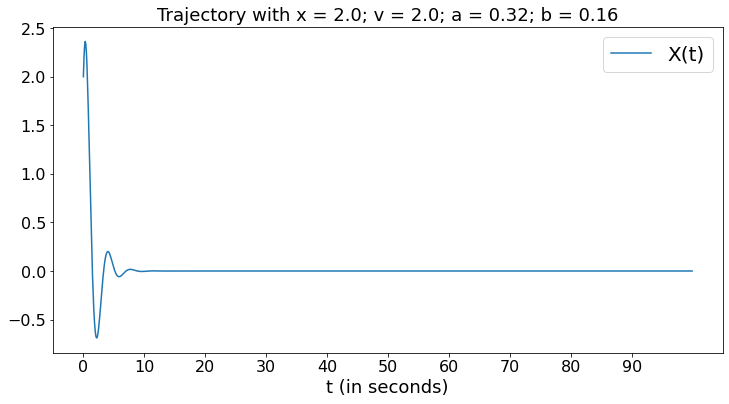

If you want to try other parameters, 
 go back to widgets above, select, and rerun this cell


In [9]:
##### ball on incline - controller based on position and velocity [slide 8]
matplotlib.rcParams.update(params)
print('We try the optimized controller with different initial conditions x and v')
    
a = aOpt
b = bOpt
    
def rollBall0(x,v,T):
    epsilon = 0.1 # time step, in seconds
    N = round(T/epsilon)
    M = round(1/epsilon)
    F = round(T/10)
    G = round(N/10)
    X = np.zeros(N)
    V = np.zeros(N)
    C = 0
    m = 0
    X[0] = x
    V[0] = v
    for n in range(N-1):
        X[n+1] = X[n] + epsilon*V[n]
        alpha = max(- 1, min(1,a*X[n] + b*V[n] ))
        V[n+1] = V[n] - epsilon*9.81*np.sin(alpha)
    plt.plot(X, label ='X(t)')
    plt.xticks(np.arange(0,N,G),np.arange(0,T,F))
    plt.xlabel('t (in seconds)')
    plt.legend()
    plt.title('Trajectory with x = ' + str(x) +'; v = '+str(v) + '; a = ' + str(a)+'; b = '+str(b))
    plt.show()

rollBall0(x,v,T)  
print('If you want to try other parameters, \n go back to widgets above, select, and rerun this cell')

## Adding noise

To verify the robustness of the controller, we add some noise to the motion of the marble.  Specifically, we simulate the action of wind on the marble by perturbing the acceleration.  We use the model

$$v[n+1] = v[n] - 0.1 \times 9.81 \times \sin(ax[n] + bv[n]) + z[n]$$

where the $z[n]$ are i.i.d. normal random variables with mean $0$ and variance $\sigma^2$. The variance can be adjusted with a slider.  The simulation shows that the controller is good at maintaining the marble close to the center of the board. This example illustrates the power of **feedback**.


In [10]:
def dummy(xd,vd,sd,Td):
    global x,v,s,T
    x,v,s,T = float(xd),float(vd),float(sd),int(Td)
    
xd = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='x',disabled=False)
vd = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='v',disabled=False)
sd = widgets.Dropdown(options=['0', '0.05', '0.1','0.15','0.2','0.25','0.3'],value='0.1',description='s',disabled=False)
Td = widgets.Dropdown(options=['5', '10', '20','30','50','100','150','200','300','400','500'],value='100',description='v',disabled=False)
z = widgets.interactive(dummy, xd = xd,vd = vd, sd=sd,Td = Td) 
display(z)

interactive(children=(Dropdown(description='x', index=7, options=('-5', '-4', '-3', '-2', '-1', '0', '1', '2',…

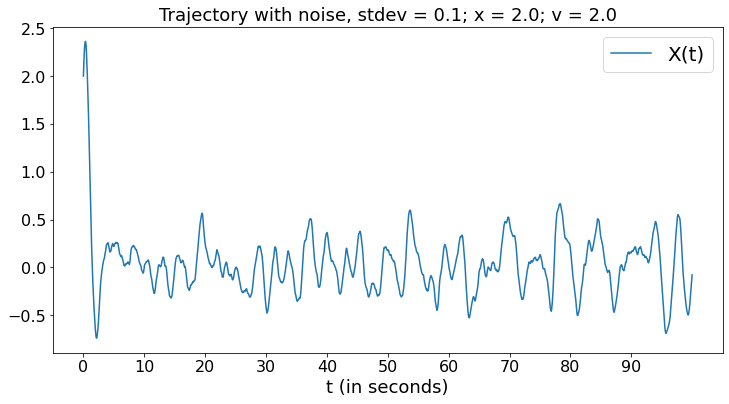

If you want to try other parameters, 
 go back to widgets above, select, and rerun this cell


In [11]:
# rolling ball on incline with noise 

a = aOpt
b = bOpt

def rollBall1(x,v,sigma,T):
    epsilon = 0.02 # time step, in seconds
    N = round(T/epsilon)
    M = round(1/epsilon)
    F = round(T/10)
    G = round(N/10)
    X = np.zeros(N)
    V = np.zeros(N)
    C = 0
    m = 0
    X[0] = x
    V[0] = v
    for n in range(N-1):
        X[n+1] = X[n] + epsilon*V[n]
        alpha = max(- 1, min(1,a*X[n] + b*V[n] ))
        V[n+1] = V[n] - epsilon*9.81*np.sin(alpha)+ np.random.normal(0,sigma)
    plt.plot(X, label ='X(t)')
    plt.xticks(np.arange(0,N,G),np.arange(0,T,F))
    plt.xlabel('t (in seconds)')
    plt.legend()
    plt.title('Trajectory with noise, stdev = '+str(sigma)+'; x = ' + str(x) +'; v = '+str(v))
    plt.show()
    
rollBall1(x,v,s,T) 
print('If you want to try other parameters, \n go back to widgets above, select, and rerun this cell')

# Marble on a Plate

At first glance, a marble on a plate looks like a much more complex control problem than on a board. 
![title](Figures/marble2.pdf)

We now control two angles: one for each axis.  If we assume a linear control, each angle is now a function of the two-dimensional position and the two-dimensional velocity. Thus, there are four parameters for each angle, for a total of eight parameters. If each parameter can take $101$ different values, as in the one-dimensional example, there are more than $10^8$ possible vectors of parameters to explore.  This is prohibitive.  

However, if we look more closely at the problem, we realize that the motions along the two directions are decoupled. Thus, it suffices to use the optimized one-dimensional controller in each direction.  The cell below simulates that approach.

This example is a simple illustration of the fact that some **domain knowledge** can guide the selection of the controller.  One should not use a blind black-box approach. If it is a nail, use a hammer.  But, if it is a screw, use a screwdriver.

In [12]:
def dummy(x0d,v0d,x1d,v1d,Td):
    global x0,v0,x1,v1,T
    x0,v0,x1,v1,T = float(x0d),float(v0d),float(x1d),float(v1d),int(Td)
    
x0d = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='x0',disabled=False)
v0d = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='2',description='v0',disabled=False)
x1d = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='-1',description='x1',disabled=False)
v1d = widgets.Dropdown(options=['-5', '-4', '-3','-2','-1','0','1','2','3','4','5'],value='-2',description='v1',disabled=False)
Td = widgets.Dropdown(options=['5', '10', '20','30','50','100','150','200','300','400','500'],value='100',description='v',disabled=False)
z = widgets.interactive(dummy, x0d = x0d,v0d = v0d, x1d=x1d,v1d=v1d,Td = Td) 
display(z)

interactive(children=(Dropdown(description='x0', index=7, options=('-5', '-4', '-3', '-2', '-1', '0', '1', '2'…

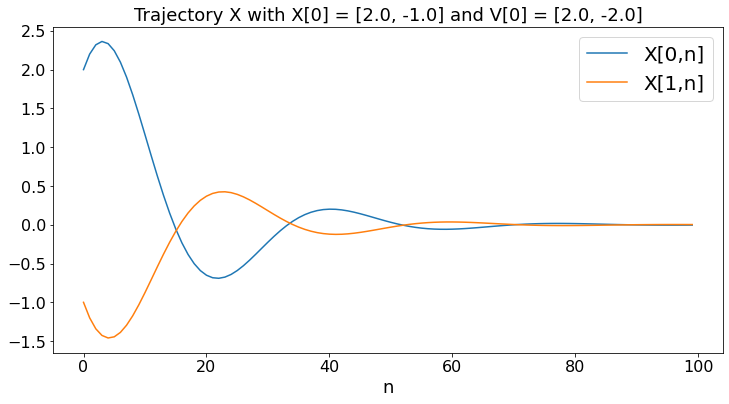

If you want to try other parameters, 
 go back to widgets above, select, and rerun this cell


In [13]:
# 2D rolling ball
matplotlib.rcParams.update(params)

a = aOpt
b = bOpt

    
def rollBall2(x0,x1,v0,v1,N):
    X = np.zeros([2,N])
    V = np.zeros([2,N])
    X[:,0] = [x0,x1]
    V[:,0] = [v0,v1]
    for i in range(2):        
        for n in range(N-1):
            X[i,n+1] = X[i,n] + 0.1*V[i,n]
            alpha = a*X[i,n] + b*V[i,n]
            V[i,n+1] = V[i,n] - 0.98*np.sin(alpha)
    for i in range(2):
        plt.plot(X[i,:],label='X['+str(i)+',n]')
    plt.title('Trajectory X with X[0] = ['+ str(round(x0,2))+ ', ' + str(round(x1,2))+'] and V[0] = ['+ str(round(v0,2))+', '+str(round(v1,2))+']')
    plt.xlabel('n')
    plt.legend()
    plt.show()    

rollBall2(x0,x1,v0,v1,T)
print('If you want to try other parameters, \n go back to widgets above, select, and rerun this cell')

# Queuing System

To illustrate the control of a **stochastic system**, we consider the queuing system shown below. 

![title](Figures/queue.pdf)

The model is in discrete time. At each step $n$, a new customer arrives with probability $\lambda$ and a service in progress terminates with probability $\mu_n$.  Here, $\mu_n$ is the controlled service rate.  We can choose a slow service rate $\mu_n = 0.2$
or a faster service rate $\mu_n = 0.4$, say by hiring a co-worker to speed up the processing.  The goal is to choose the service rate as a function of the number $X_n$ of customers in the queue to minimize the expected cost of running the system. This expected cost is

$$C = E\left[\sum_{n=0}^N (X_n + \alpha \mu_n)\right].$$

This cost has two components: the cost of having customers waiting in the queue and the cost of service. The constant $\alpha$ reflect the relative weights of these two costs.

## Brute-Force Method

We explore a parametric control $\mu_n = 0.2 + 0.2 \times 1\{X_n > a\}$ where $a$ is the parameter.  It is sensible to speed up service when there are many customers waiting.  In the cell below, we simulate the system many times for different values of $a$ in order to find the best one. The simulations show that $a = 3$ is best when $\lambda = 0.2$.

The main point of this example is that if the system is stochastic, one needs a **large number of simulation runs** in order to estimate the expected cost.  Even if the number of parameter values to explore is small, the brute-force approach is **prohibitive** for most practical stochastic systems.

Algorithm is running.  Please wait.....
Almost done ...


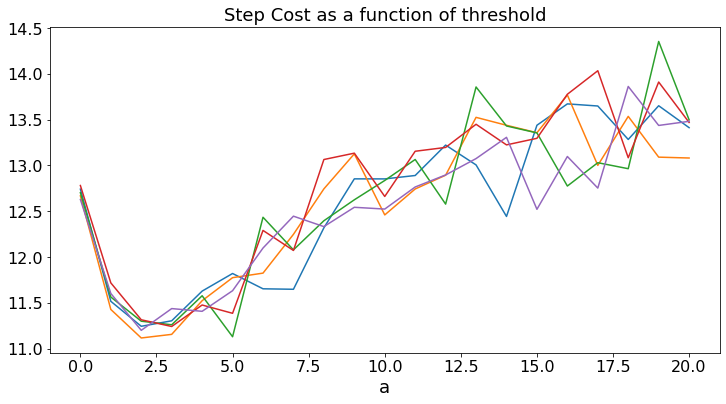

In [135]:
# Choosing a service rate: Brute-force learning

def queuingCost(a,lamb,alpha,N):
    X = np.zeros(N)
    C = 0
    for n in range(N-1):
        mu = 0.2 + 0.2*(X[n] > a)
        X[n+1] = max(0,X[n] - np.random.binomial(1,mu)) + np.random.binomial(1,lamb)
        C += X[n] + alpha*mu
    return C
        
def bruteForceQueue(lamb,alpha,N):
    print('Algorithm is running.  Please wait.....')
    K = 20
    M = 60
    for instance in range(5):
        if instance == 2:
            print('Almost done ...')
        C = np.zeros(K+1)
        for a in range(K+1):
            for simStep in range(M):
                C[a] += queuingCost(a,lamb,alpha,N)            
        minC = min(C)
        minStepCost = minC/(M*N)
        a = np.argmin(C)
        plt.plot(C/(M*N))
    plt.title('Step Cost as a function of threshold')
    plt.xlabel('a')
    plt.xticks(range(K))
    plt.show()
    
bruteForceQueue(0.2,40,400)            

## Dynamic Programming

Optimizing parametric controllers with a brute-force evaluation of all the possible values of parameters is intractable for most practical systems. **Dynamic programming** is a methodology to derive the optimal controller.  You will note that this approach does not assume that the optimal service rate if of the form $0.2 + 0.1 \times 1\{x > a\}$.  It only assumes that the optimal service rate is a function of $x$.

Let $V(x)$ be the minimum possible value of the **expected total discounted cost**:

$$ V(x) = \min E \left[ \sum_{n=0}^\infty \rho^n (X_n + \alpha \mu_n) \mid X_0 = x\right].$$

The minimum is over all possible strategies where we choose
the service rate $\mu_n \in \{0.2, 0.4\}$ as a function of $n$ and $X_n$. The quantity $V(x)$ is called the **value of state** $x$ and the function $V(\cdot)$ is called the **Value Function**.

Here, $\rho \in (0, 1)$ is the **discount factor**. It captures the fact that future costs are less important than the current cost, say because of inflation.  If $\rho \approx 1$, the problem is essentially the same as minimizing the total cost over a large horizon or minimizing the average cost per step, as we explain next.

Intuitively, one should expect that the optimal policy does not depend on time because the infinite future always looks the same given the value of the current state $X_n$.  Also, if one uses the optimal policy, the queuing system behaves like a Markov chain that is irreducible since the queue always has a chance to get empty and to reach any state from the empty state $x = 0$.  Moreover, choosing $\mu = 0.4$ in all states makes the chain positive recurrent and have a finite discounted cost (because the likelihood of $x$ decreases exponentially in $x$). Consequently, that is also be the case under the optimal policy.  Consequently, under the optimal policy, the probability mass function of $X_n$ approaches some distribution $\pi$ that is invariant.  If $\rho \approx 1$, the expected cost at step $n$ then approaches the expected value of $X_n + \beta g(X_n)$ under $\pi$ where $\mu_n = g(X_n)$ is the optimal policy.  Hence, the expected total discounted cost approaches

$$ \sum_{n=0}^\infty \rho^n \sum_x \pi(x)  (x + \alpha g(x)).$$

This expression is equal to

$$(1 - \rho)^{-1} \sum_x \pi(x) (x + \alpha g(x)) = (1 - \rho)^{-1} A$$

where $A$ is the average cost per step.  

Let $Q(x, u)$ be the minimum value of the total expected discounted cost given that $X_0 = x$
and that $\mu_0 = u$.  Thus, at step $0$ we choose the service rate $u \in \{0.2, 0.4\}$ and
after step $1$ we use the strategy $\mu(X_n)$ that achieves the minimum expected total discounted cost.  Note that $V(x) = \min \{Q(x,0.2), Q(x, 0.4)\}$.  Also, the optimal policy is the value of $\mu$ that achieves the minimum in this expression.

The key observation is that if $X_0 = x$ and $\mu_0 = u$, we pay the cost $x + \alpha u$
at step $0$ and the minimum cost starting from $X_1$ is then $\rho V(X_1)$.  Indeed, the problem of minimizing the cost starts afresh from $X_1$ at time $1,$ but all the costs are discounted by a factor $\rho$ more than if we started from time $0$.  For instance, the cost starting from $X_1$ at time $1$ is multiplied by $\rho$ whereas if we started from $X_1$ at time $0$ it would be multipled by $\rho^0 = 1$.

Hence,

$$Q(x, u) = x + \alpha u + \rho E[ V(X_1) \mid X_0 = x, \mu_0 = u].$$

Also,

$$V(x) = \min \{Q(x, 0.2), Q(x, 0.4)\}.$$

Accordingly,

$$Q(x, u) = x + \alpha u + \rho E[ \min(Q(X_1,0.2), Q(X_1,0.4)) \mid X_0 = x, \mu_0 = u].$$

These equations are the **Dynamic Programming Equations.**  If we solve these equations, as we noted above, the best action to take when the state is $x$ is the value of $u$ that achieves the minimum of $Q(x,0.2)$ and $Q(x, 0.4)$.  

If $X_0 = x$ and $\mu_0 = u$, then $X_1 = x + 1$ with probability $\lambda (1 - \mu)$, and similarly for the other possibilities.  Thus, it is easy to write down the dynamic programming equations.  One complication is that they are nonlinear (because of the minimum).  Another is that there are infinitely many such equations (one for each $x$ and for each $u$).  To address the second complication, we truncate the set of values of $x$ to $\{0, 1, \ldots, K-1\}$.
To handle the first complication, we note that the equations have the form 

$$Q = F(Q)$$

where $Q$ is the vector of values of $Q(x, u)$ for $x$ in $\{0, 1, \ldots, K-1\}$ and $u$ in $\{0.2, 0.4\}$.  To solve these **fixed-point equations**, we use the iteration $Q_{t+1} = F(Q_t)$.  One can show theoretically that this iteration converges.  We do the calculations in the next cell.  

You can verify that $(1 - \rho) V(x)$ approaches some limit as $\rho$ approaches $1$. That limit is the minimum expected cost per step. Moreover, you should appreciate the benefits of the dynamic programming approach: 1) it computes the optimal policy without assuming some parametric form; 2) the calculation is much faster than the brute-force approach that requires a long simulation for each possible value of the parameter.

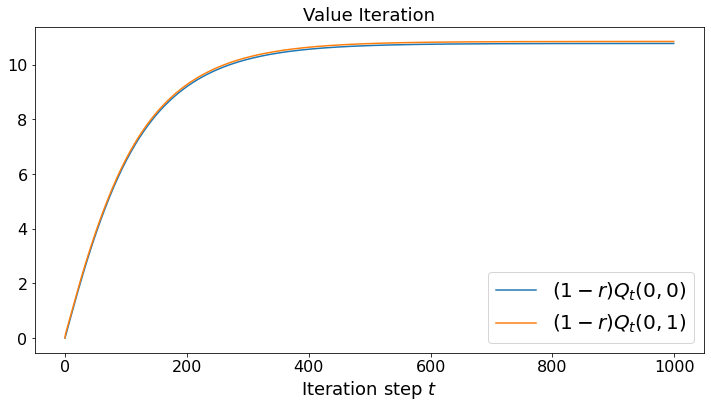

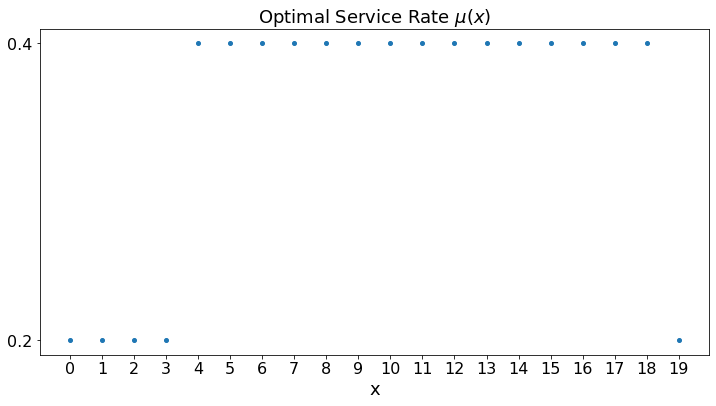

In [142]:
K = 20 # number of states
U = [0.2, 0.4] # possible values of mu
lam = 0.2 # arrival rate
rho = 0.99 # discount rate
alpha = 40

T = 1000 # number of iterations
Q = np.zeros([T,K,2])
def EV(x,u,W): # Expected value of V(X1) given X0 = x and mu0 = U[u]
    mu = U[u]
    z = lam*(1 - mu)*min(W[min(K-1,x+1),0],W[min(K-1,x+1),1])
    z += (1 - lam)*mu*min(W[max(0,x-1),0],W[max(0,x-1),1])
    z += (lam*mu + (1 - lam)*(1 - mu))*min(W[x,0],W[x,1])
    z = x + alpha*mu + rho*z
    return z

for t in range(1,T):
    for x in range(K):
        for u in range(2):
            Q[t,x,u] = EV(x,u,Q[t-1,:,:])
            
plt.title('Value Iteration')
plt.plot(range(T),(1 - rho)*Q[:,0,0],label='$(1 - r)Q_t(0,0)$')
plt.plot(range(T),(1 - rho)*Q[:,0,1],label='$(1 - r)Q_t(0,1)$')
plt.xlabel('Iteration step $t$')
plt.legend()
plt.show()

mu = np.zeros(20)
for x in range(20):
    mu[x] = 0.2 + 0.2*np.argmin(Q[T-1,x,:])
plt.title('Optimal Service Rate $\mu(x)$')
plt.scatter(range(20),mu)
plt.xlabel('x')
plt.yticks([0.2,0.4])
plt.xticks(np.arange(20))
plt.show()
                                  

## Policy Iteration

The **policy iteration approach** recursively updates the policy instead of updating the value function.  

The basic idea is as follows.  Assume that one uses the policy $\mu = g(x)$ at every step.
Let $C(g, x)$ be the expected total discounted cost when using that poliicy given that $X_0 = x$.  We claim that

$$C(g, x) = x + \alpha g(x) + \rho E[C(g, X_1) \mid X_0 = x, \mu_0 = g(x)].$$

Indeed, the cost at step $0$ is $x + \alpha g(x)$ and the cost starting from $X_1$ at step $1$ is the same as starting from $X_1$ at step $0$, except that it is discouned by an additional factor $\rho$.  

These equations are linear in the unknowns $C(g, x)$.  It is then easy to solve for these unknowns.  (After truncating the state space to $\{0, 1, \dots, K-1\}$, there are only $K$ unknowns.) This is the **policy evaluation** step.

The policy iteration then proceeds as follows.  Let us imagine that the policy is $\mu = g(x)$ at steps $1, 2, \ldots$.  The expected cost starting from step $1$ is then $C(g, X_1)$.  If we use the service rate $u$ at step $0$ and if $X_0 = x$, the total expected discounted cost is then

$$x + \alpha g(x) + \rho E[C(g, X_1) \mid X_0 = x, \mu_0 = g(x)].$$

At step $0$, let us choose the value of $u$ that minimizes this expression.  This defines a new policy $g'(x)$.  This is the **policy improvement step**.  One can then evaluate this new policy as before, and then improve that policy.  The policy iteration algorithm iterates the policy evaluation and policy improvement steps.  We do the calculations in the next cell.

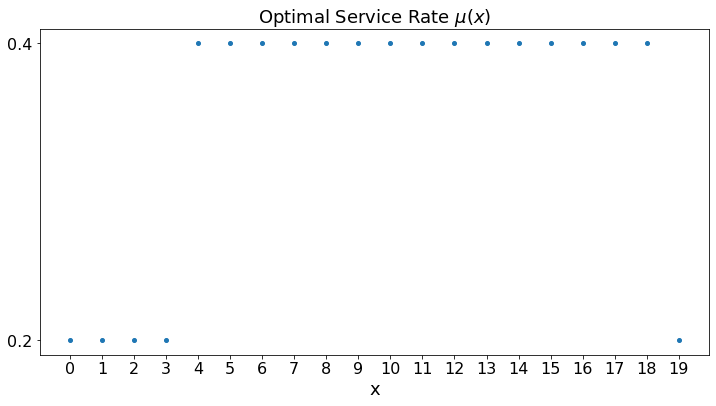

In [141]:
import scipy
from scipy import linalg
K = 20 # number of states
U = [0.2, 0.4] # possible values of mu
lam = 0.2 # arrival rate
rho = 0.99 # discount rate
alpha = 40

T = 100 # number of iterations
C = np.zeros([T,K])
g = np.full((K, T), 0, dtype=int) # 2D array of integers 0

def PT(g): # calculation of P[x,x'] = P[X_1 = x' | X_0 = x, mu = U[g(x)]]
    P = np.zeros([K,K]) 
    for x in range(K):
        mu = U[g[x]]
        if x > 0:
            P[x,x-1] = (1 - lam)*mu
        if x < K-1:
            P[x, x+1] = lam*(1 - mu)
        P[x,x] = 1 - sum(P[x,:])
    return P

def SC(g): # calculation of b[x] = x + alpha*U[g(x)] = step cost
    w = np.zeros(K)
    for x in range(K):
        mu = U[g[x]]
        w[x] = x + alpha*mu
    return w
    
def PEV(g): # Evaluation of C(g,x) where g(x) is in [0,1] for x in 0, ..., K-1    
    b = SC(g)
    P = PT(g)
    # Solve the equations C = b + rho*P*C, i.e., AC = b with A = I - rho*P
    A = np.identity(K) - rho*P
    return scipy.linalg.solve(A,b)

def CP(u,g): # evaluation of SC(u) + rho*C(g)
    mu = U[u]
    W = np.zeros(K)
    V = np.dot(PT([u for _ in range(K)]),PEV(g))
    for x in range(K):
        W[x] = x + alpha*mu + rho*V[x]
    return W

for t in range(1,T):
    C[t,:] = PEV(g[:,t-1]) # policy evaluation
    for x in range(K): # policy improvement
        g[x,t] = np.argmin([CP(0,g[:,t-1])[x],CP(1,g[:,t-1])[x]])

mu = np.zeros(K)
for x in range(K):
    mu[x] = 0.2 + 0.2*g[x,T-1]
plt.title('Optimal Service Rate $\mu(x)$')
plt.scatter(range(K),mu)
plt.xlabel('x')
plt.yticks([0.2,0.4])
plt.xticks(np.arange(K))
plt.show()

# Cache Replacement Problem

We explain dynamic programming in the case of a total expected discounted cost for a controlled Markov process. 

## Model

Specifically, we explore the cache replacement problem illustrated below. We choose this example because a brute-force approach is prohibitive; the example demonstrates the superiority of a more systematic methodology. Also, the example is simple enough to develop an intuitive understanding of what is going on. Moreover, the example allows us to develop the key ideas with a minimal amount of notation.
![title](Figures/cache.pdf)
There is a buffer that can contain only one item $Y_n$.  At time $n$, the request is for item $X_n$ and we decide
to keep item $Y_n$ in the buffer.  This item $Y_n$ is either $X_n$ or the item that was in the buffer at step $n-1$. Then, at step $n+1$, the request is for item $X_{n+1}$, as shown in the figure.  If $X_{n+1} = Y_n$, we are lucky and we can serve the request at no cost.  However, if $X_{n+1} \neq Y_n$, we have to go fetch $X_{n+1}$ at a unit cost.  We then have to decide whether to keep $Y_n$ in the buffer or to replace it by $X_{n+1}$.  The **cache replacement** policy (keep or replace) tries to minimize the expected cost of fetching items.

The expected cost is 

$$C = E\left[\sum_{n=0}^\infty \rho^n 1\{X_{n+1} \neq Y_n\}\right].$$

In this expression, $1\{X_{n+1} \neq Y_n\}$ is equal to one if $X_{n+1} \neq Y_n$ and to zero if $X_{n+1} = Y_n$. Thus, $1\{X_{n+1} \neq Y_n\}$ is the cost incurred at step $n$.
Also, $\rho \in (0, 1)$ is the **discount factor**. It captures the fact that future costs are less important that current costs. You can view discounting either as an economic reality or as a mathematical artefact that enables to study a very long time horizon without the cost going to infinity.  (Recall that the sum of $\rho^n$ is finite, so that the total cost is bounded.)

We assume that the requests form a Markov chain defined by a transition matrix $P$ such that

$$P[X_{n+1} = x' \mid X_n = x, X_{n-1}, \ldots, X_0] = P(x, x').$$

One can show that the optimal cache replacement policy is the same at all steps. One says that the optimal policy is **stationary**. Intuitively, the future always looks the same since we face an infinite total discounted cost that always has the same formulation. A **stationary cache replacement policy** is defined by a function $\gamma$ such that $Y_{n+1} = \gamma(X_{n+1}, Y_n) \in \{X_{n+1}, Y_n\}$.  Indeed, when a new item $X_{n+1}$ is requested and $Y_n$ is in the buffer, one has to decide which of $\{X_{n+1}, Y_n\}$ to keep in the buffer. Thus, for each pair of distinct items $(x, y)$, there
are two possible values of $\gamma(x, y)$: either $x$ or $y$. If there are $K$ possible items, there are
$M = K(K-1)/2$ pairs $(x, y)$ of distinct items.  Hence, there are $2^M$ possible cache replacement policies. This number $M$ is very large even for small values of $M$. For instance, it is about $10^{13}$ when $K = 10$. Consequently, a brute-force approach to choose the policy is prohibitive.

The **state** of the system at step $n$ is $(X_n, Y_n)$.  By definition, the state is the minimum amount of information one needs to predict the future of the system.  We need to remember $X_n$ because the likelihood of future requests depends on $X_n$ since the requests form a Markov chain.  Also, we need to know $Y_n$ because the item in the buffer affects what can happen next.  There are $K \times K$ possible states since there are $K$ possible values of $X_n$ and $K$ possible values of $Y_n$.


## Two Examples

### Example 1: i.d.d.

Assume that the requests $X_n$ are **i.i.d.** with $P(X_n = x) = \pi(x)$ for $x \in {\cal X}$.  (I.i.d. means independent and identically distributed.) This is a particular Markov chain with $P(x, y) = \pi(y)$ for all $x, y$. 

In this case, it is intuitively clear that one should always keep in the buffer the item most likely to be requested.  That is,

$$\gamma(x, y) = x \mbox{ if } \pi(x) > \pi(y) \mbox{ and } \gamma(x, y) = y \mbox{ otherwise}.$$

This example is useful for checking that our algorithm is implemented correctly.

### Example 2: two-state Markov chain

Assume the requests are a Markov chain with the transition diagram shown below.
![title](Figures/cache2.pdf)
This diagram illustrates the transition matrix.  It means that 

$$P(0, 0) = 0.6, P(0, 1) = 0.4, P(1, 0) = 0.3, \mbox{ and } P(1, 1) = 0.7.$$

For this transition matrix, the optimal policy is to always replace the item by a different requested item.  For instance, if $0$ is in the buffer and item $1$ is requested, then we should replace $0$ by $1$ in the buffer.  To see this, note that if the request is for item $1$, then the most likely next request is again for item $1$, and similarly if the request is for item $0$.  Note that item $1$ is requested more frequently than item $0$, on average.  However, one does not always keep item $1$ in the buffer, in contrast with the previous example.  This example is also useful to check our algorithm implementation.

For a more general case, the optimal policy is not intuitively clear.  


## Dynamic Programming Equations

Let $Q(x, y)$ be the minimum total expected discounted cost given that $X_0 = x$ and $Y_0 = y$.
Here, $y$ is the item that was in the before when we started, and we decide to keep it in the buffer.  Similarly, $Q(x, x)$ 
is the minimum total expected discounted cost given that $X_0 = x$ and $Y_0 = x$, i.e., when we
replace $y$ by $x$.  In particular, the minimum total expected cost is $\min \{Q(x, x), Q(x, y)\}$
and the optimal policy is then such that 

$$\gamma(x, y) = x \mbox{ if } Q(x, x) < Q(x, y) \mbox{ and } \gamma(x, y) = y \mbox{ otherwise.} ~~~~(1)$$



This minimum cost corresponds to using the optimal cache replacement policy $\gamma$ at every step, starting at step $0$.  This cost is then

$$Q(x, y) = E[\sum_{n=0}^\infty \rho^n 1\{X_{n+1} \neq Y_n\} \mid X_0 = x, Y_0 = y].$$


This cost has two components: the cost of step $n = 0$ and the cost starting from step $1$.
The cost of step $n = 0$ is

$$\sum_{x'} P(x, x') 1\{x' \neq y\}$$

since, given $X_0 = x$, one has $X_1 = x'$ with probability $P(x, x')$. The cost starting from step $1$ is the cost of using the optimal policy, starting from $x'$ with probability $P(x, x')$.  With that probability $P(x, x')$,
the minimum cost is $\min \{\rho Q(x', x'), \rho Q(x', y)\}$. Indeed, $\rho Q(x', x')$ is the minimum
cost starting from step $1$ when $x'$ last arrived and we decide to keep $x'$ in the buffer instead of $y$. The factor $\rho$ is because every step starting from step $1$ occurs one step later than if we were to start from step $0$, so that the cost of each step is discounted by an additional factor $\rho$.  Similarly, $\rho Q(x', y)$ is he minimum
cost starting from step $1$ when $x'$ last arrived and we decide to keep $y$ in the buffer.  

Adding these two components, we find that

$$Q(x, y) = \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} P(x, x') \min \{\rho Q(x', x'), \rho Q(x', y)\}.~~~~(2)$$

These are the **dynamic programming equations** for the minimum cost.  If we can solve them, then we can find the optimal policy as we saw in (1).

## Value Iteration Algorithm

The dynamic programming equations (2) are a system of $K^2$ nonlinear equations.  They are **fixed-point equations** of the form $Q = F(Q)$ where $F(\cdot)$ is the right-hand side of (2).  To solve them, we use the iteration $Q_n = F(Q_{n-1})$, starting with $Q_0 = 0$.  That is,

$$Q_n(x, y) = \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} P(x, x') \min \{\rho Q_{n-1}(x', x'), \rho Q_{n-1}(x', y)\}.~~~~(3)$$

The equations (3) form the **value iteration algorithm**. One can show that $Q_n \to Q$. The key idea is that because $\rho < 1$ the distance between successive $Q_n$ gets smaller geometrically fast. 

The cell below implements the value iterations algorithm. It also plots the successive values of $Q_n$ and the policy corresponding to each $Q_n$.

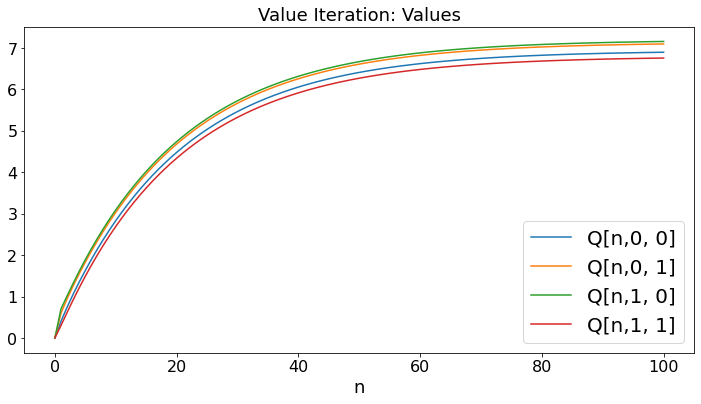

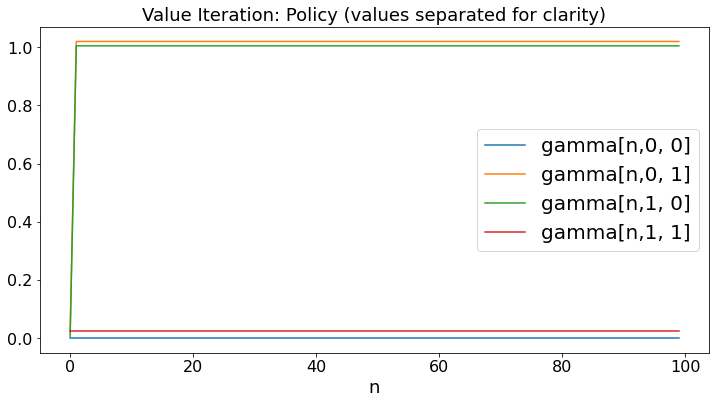

In [16]:
# Caching Example: Value Iteration

matplotlib.rcParams.update(params)

P = np.array([[0.6, 0.4],[0.3, 0.7]])
dim = len(P)
N = 100
rho = 0.95
Q = np.zeros([N+1,dim,dim])
gamma = np.zeros([N,dim,dim])
for n in range(N):
    for i in range(dim):
        for j in range(dim):
            gamma[n,i,j] = Q[n,i,i] < Q[n,i,j]
    W = np.zeros([dim,dim])
    for i in range(dim):
        for j in range(dim):            
            for k in range(dim):
                W[i,j] += P[i,k]*((k != j) + rho*min(Q[n,k,k],Q[n,k,j]))
    Q[n+1,:,:] = W
    
for i in range(dim):
    for j in range(dim):
        plt.plot(Q[:,i,j], label = 'Q[n,'+str(i)+', '+str(j)+']')
plt.title('Value Iteration: Values')
plt.legend()
plt.xlabel('n')
plt.show()

for i in range(dim):
    for j in range(dim):
        plt.plot(gamma[:,i,j]+0.005*i+0.02*j, label = 'gamma[n,'+str(i)+', '+str(j)+']')
plt.title('Value Iteration: Policy (values separated for clarity)')
plt.legend()
plt.xlabel('n')
plt.show()

## Policy Iteration

The **policy iteration algorithm** is another approach for solving optimal control problems. It goes as follows.  Say that one uses some policy $\gamma$ at each step. Assume also that at step $0$, the request if for item $x$ and that one keeps item $y$ in the buffer.  The expected total discounting cost $C(x, y)$ is such that

$$C(x, y) = \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} P(x, x')\rho C(x', \gamma(x',y)).~~~~ (4)$$

Indeed, the cost has two components: the cost of the first step and the cost starting from step $1$. Let us examine the cost starting from step $1$. With probability $P(x, x')$, one starts from step $1$ when the last request was $x'$ and one decides to keep $\gamma(x', y)$ in the buffer, by definition of the policy $\gamma$.  Since every step is discounted by one factor $\rho$ more than starting from step $0$, the expected cost starting from step $1$ is then $\rho C(x', \gamma(x', y))$. This justifies (4).

The equations (4) form a system of $K^2$ **linear** equations.  One can solve them using algebra.  
This is called **policy evaluation**: one computes the expected total discounted cost of the policy $\gamma$.

The **policy improvement step** is then as follows.  Assume that one uses the policy $\gamma$ starting from step $1$ and that $C(x, y)$ is the expected total cost of that policy, starting from step $1$.  Assume that at step $0$ the request is for item $x$ and that $y$ is in the buffer just before step $0$.
If we decide to keep item $y$ in the buffer, we face the expected cost

$$\sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} \rho C(x', \gamma(x', y)).$$

However, if we replace $y$ by $x$, we face the expected cost

$$\sum_{x'} P(x, x') 1\{x' \neq x\} + \sum_{x'} \rho C(x', \gamma(x', x)).$$

One then defines the new policy $\gamma'$ that choose the action that achieves the smaller of these two costs.

The **policy iteration algorithm** repeats the steps of policy evaluation and policy improvement.  We start with an arbitrary policy $\gamma_0$, say $\gamma_0(x, y) = x$ for all $(x, y)$.  Then, for $n \geq 0$, we
evaluate the policy $\gamma_n$ by solving algebraically the following linear system of equations:

$$C_n(x, y) = \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} P(x, x')\rho C_n(x', \gamma_n(x',y)).$$

One then defines the policy $\gamma_{n+1}$ as follows: $\gamma_{n+1}(x, y) = x$ if

$$\sum_{x'} P(x, x') 1\{x' \neq x\} + \sum_{x'} \rho C(x', \gamma(x', x)) < \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} \rho C(x', \gamma(x', y))$$

and $\gamma_{n+1}(x, y) = y$ otherwise. One repeats these steps until the policies stop changing. The cell below implements that algorithm and plots the successive costs $C_n$ and policies $\gamma_n$.


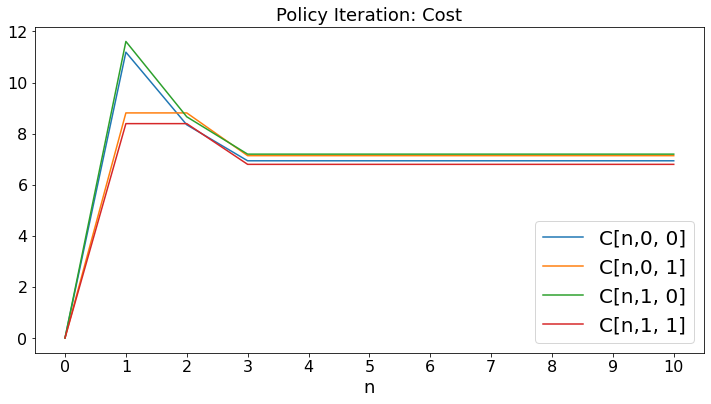

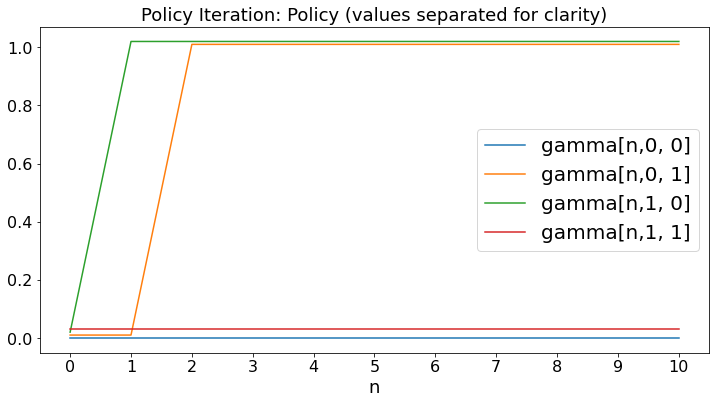

In [17]:
def policyEvaluation(rho,gamma,P):
    dim = len(P)
    C = np.zeros([dim,dim])
    A = np.zeros([dim**2,dim**2]) # Ax = b
    b = np.zeros(dim**2)
    c = 0
    for i in range(dim):
        for j in range(dim):
            for l in range(dim):
                b[dim*i+j] += P[i,l]*(l != j)
    for i in range(dim):
        for j in range(dim):
            A[dim*i + j, dim*i + j] = 1
            for l in range(dim):
                if gamma[l,j] == 0:
                    c = j
                else:
                    c = l
                A[dim*i + j, dim*l + c] -= rho*P[i,l]
    Aa = np.array(A)
    ba = np.array(b)
    X = np.linalg.solve(Aa,ba)
    for i in range(dim):
        for j in range(dim):
            C[i,j] = X[dim*i+j]
    return C
N = 10       
gamma = np.zeros([N+1,dim,dim])
C = np.zeros([N+1,dim,dim])
for n in range(N):
    C[n+1,:,:] = policyEvaluation(rho,gamma[n,:,:],P)
    for i in range(dim):
        for j in range(dim):
            gamma[n+1,i,j] = C[n+1,i,i] < C[n+1,i,j]
for i in range(dim):
    for j in range(dim):
        plt.plot(C[:,i,j],label = 'C[n,'+str(i)+', '+str(j)+']')
plt.title('Policy Iteration: Cost')
plt.xlabel('n')
plt.xticks(np.arange(N+1))
plt.legend()
plt.show()

for i in range(dim):
    for j in range(dim):
        plt.plot(gamma[:,i,j]+0.02*i+0.01*j,label = 'gamma[n,'+str(i)+', '+str(j)+']')
plt.title('Policy Iteration: Policy (values separated for clarity)')
plt.xlabel('n')
plt.xticks(np.arange(N+1))
plt.legend()
plt.show()

# Reinforcement Learning

To write down the dynamic programming equations, one needs to know the system model. In our caching example, one needs to know the transition matrix $P$. In many situations, one does not know precisely the model. For instance, the statistics of requests in the caching example change over time as new items become more popular.  Reinforcement learning combines the ideas of dynamic programming with learning.

We explain two methods: **Q-Learning** based on value iteration, and **Policy Iteration with Learning**.

## Q- Learning

Recall the dynamic programming equations (2):



$$ \small Q(x, y) = \sum_{x'} P(x, x') 1\{x' \neq y\}  + \sum_{x'} P(x, x') \min \{\rho Q(x', x'), \rho Q(x', y)\}.~~~~(2)$$



We can write them as



$$\small Q(X_n, Y_n) = E \left[ 1\{X_{n+1} \neq Y_n \} + \rho \min\{Q(X_{n+1}, X_{n+1}), Q(X_{n+1}, Y_n)\}\mid X_n, Y_n\right].$$



The key idea of Q-Learning is to replace the expectation by an approximation based on observed transitions.  Before we outline the algorithm, we explain a method for estimating an expected value.

### Estimating an expected value

Let $\{X, X_1, X_2, \ldots \}$ be i.i.d.  The strong law of large numbers says that
$$ Z_n := (X_1 + \cdots + X_n)/n \to E[X] \mbox{ as } n \to \infty.$$
Note that

$$nZ_n = X_1 + \cdots + X_n = (n-1)Z_{n-1} + X_n.$$

Hence,

$$ Z_n = \frac{n-1}{n} Z_{n-1} + \frac{1}{n} X_n.$$

With $\delta_n = 1/n$, this expression can be written as

$$Z_n = (1 - \delta_n) Z_{n-1} + \delta_n X_n.$$

This suggests that if $\delta$ is small, then
$$Z_n = (1 - \delta) Z_{n-1} + \delta X_n \mbox{ approaches } E[X] \mbox{ as } n \to \infty. ~~~ (5)$$
We test that idea in the cell below where the $X_n$ are normal with mean $A$ and variance $1$. Both $A$ and $\delta$ can be selected with the sliders.


In [18]:
def dummy(Ad,deltad):
    global A, delta
    A, delta = float(Ad), float(deltad)
    
Ad = widgets.Dropdown(options=['-10', '-8', '-6','-4','-2','0','2','4','6','8','10'],value='4',description='A',disabled=False)
deltad = widgets.Dropdown(options=['0.05', '0.1', '0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5','0.55'],value='0.15',description='delta',disabled=False)
z = widgets.interactive(dummy, Ad = Ad, deltad = deltad) 
display(z)

interactive(children=(Dropdown(description='A', index=7, options=('-10', '-8', '-6', '-4', '-2', '0', '2', '4'…

Observe the impact of delta on the convergence
The sequence z[n] converges to a neighborhood of A


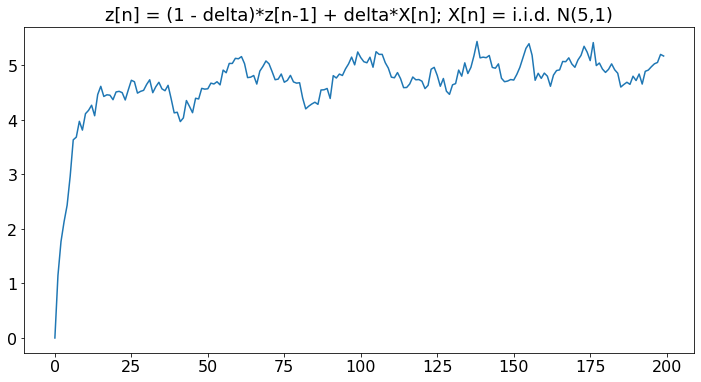

If you want to try other parameters, 
 go back to widgets above, select, and rerun this cell


In [19]:
A = 5
N = 200
Z = np.zeros(N)
def gradAlg1(A, delta):
    for n in range(1,N):
        Z[n] = (1 - delta)*Z[n-1] + delta*np.random.normal(A,1)
    plt.plot(Z)
    plt.title('z[n] = (1 - delta)*z[n-1] + delta*X[n]; X[n] = i.i.d. N('+str(A)+',1)')
    plt.show()
print('Observe the impact of delta on the convergence')
print('The sequence z[n] converges to a neighborhood of A')

gradAlg1(A, delta)
print('If you want to try other parameters, \n go back to widgets above, select, and rerun this cell')

### Q-Learning Algorithm

Consider the iteration

$$W_n(X_n, Y_n) = (1 - \delta ) W_{n-1}(X_{n-1},  Y_n) $$

$$~~~ + \delta \left[ 1\{X_{n+1} \neq Y_n\} + \rho \min \{W_{n-1}(X_{n+1}, X_{n+1}), W_{n-1}(X_{n+1}, Y_n)\} \right].~~~(6)$$


Assume that $W_n$ approaches some function $W$ as $n \to \infty$ (which can be proved).  Then one has


$$W_n(X_n, Y_n) \approx (1 - \delta ) W_{n-1}(X_{n-1},  Y_n) $$

$$~~~ + \delta \left[ 1\{X_{n+1} \neq Y_n\} + \rho \min \{W(X_{n+1}, X_{n+1}), W(X_{n+1}, Y_n)\} \right].$$


In view of (5), this implies that 


$$W_n(X_n, Y_n) \to E\left[ 1\{X_{n+1} \neq Y_n\} + \rho \min \{W(X_{n+1}, X_{n+1}), W(X_{n+1}, Y_n)\} \mid X_n, Y_n \right].$$


But, since $W_n \to W$, we conclude that


$$W(X_n, Y_n) \approx E\left[ 1\{X_{n+1} \neq Y_n\} + \rho \min \{W(X_{n+1}, X_{n+1}), W(X_{n+1}, Y_n)\} \mid X_n, Y_n \right].$$


These are the dynamic programming equations satisfied by $Q$.  Hence, $W \approx Q$ and $W_n \to Q$.  In other words, the iteration (6) approaches $Q$.  The iteration (6) is called the **Q-Learning Algorithm**.  

The next cell implements that algorithm.



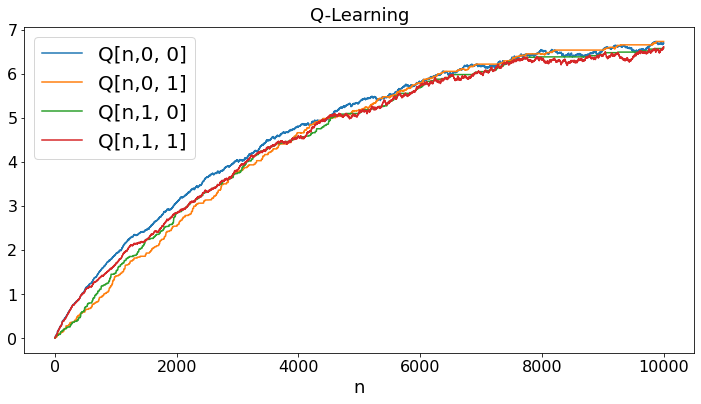

In [20]:
# Q-Learning Algorithm


def discreteRV(L): # L is a list of nonnegative numbers
    # the function returns a RV in range(len(L)) with probabilities
    # proportional to the corresponding elements of L
    L = np.array(L)
    L = L/sum(L) # we first normalize
    S = 0
    U = np.random.uniform(0, 1)
    for n in range(len(L)):
        S += L[n]
        if U < S:
            break
    return n
            

NP = np.zeros([dim,dim])


delta = 0.02

N = 10000

Q = np.zeros([N,dim,dim])
W = np.zeros([dim,dim])
X = 0 # first item
Y = 0 # item in buffer

for n in range(N-1):
    Xp = discreteRV(P[X,:])
    W[X,X] = (1 - delta)*Q[n,X,X]+delta*(Xp != X) + delta*rho*min(Q[n,Xp,Xp],Q[n,Xp,X])
    W[X,Y] = (1 - delta)*Q[n,X,Y]+delta*(Xp != Y) + delta*rho*min(Q[n,Xp,Xp],Q[n,Xp,Y])
    Q[n+1,:,:] = W
    if np.random.binomial(1,0.5) == 1: # forced learning
        Y = Xp
    else:
        if Q[n+1,Xp,Xp] < Q[n+1,Xp,Y]:
            Y = Xp
    X = Xp


for i in range(dim):
    for j in range(dim):
        plt.plot(Q[:,i,j],label = 'Q[n,'+str(i)+', '+str(j)+']')
plt.title('Q-Learning')
plt.xlabel('n')
plt.xticks(np.arange(N+1, step=int(N/5)))
plt.legend()
plt.show()

## Policy Iteration with Learning

Recall the policy iteration algorithm:

$$C_n(x, y) = \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} P(x, x')\rho C_n(x', \gamma_n(x',y)).~~~(7)$$

The policy $\gamma_{n+1}$ is defined as follows: 

$$\gamma_{n+1}(x, y) = x $$

if 

$$\sum_{x'} P(x, x') 1\{x' \neq x\} + \sum_{x'} \rho C(x', \gamma(x', x)) < \sum_{x'} P(x, x') 1\{x' \neq y\} + \sum_{x'} \rho C(x', \gamma(x', y))$$

and 

$$\gamma_{n+1}(x, y) = y \mbox{ otherwise.}$$

We note that (7) can be written as

$$C_n(X_n,Y_n) = E\left[ 1\{X_{n+1} \neq Y_n \} + \rho C_n(X_{n+1}, \gamma_n(X_{n+1}, Y_n)) \mid X_n, Y_n\right].$$

Consider the iteration

$$ U_n (X_n, Y_n) = (1 - \delta) U_{n-1} (X_n, Y_n)  + \delta  \left[ 1\{X_{n+1} \neq Y_n\} + \rho U_{n-1}(X_{n+1}, \gamma_n(X_{n+1}, Y_n)) \right].$$

Assume that $U_n$ approaches some function $U$ as $n \to \infty$ and that $\gamma_n$ approaches some $\gamma$ (which can be shown). Then

$$U_n (X_n, Y_n) \approx (1 - \delta) U_{n-1} (X_n, Y_n)  + \delta  \left[ 1\{X_{n+1} \neq Y_n\} + \rho U(X_{n+1}, \gamma(X_{n+1}, Y_n)) \right].$$

In view of (5), this implies that

$$U_n(X_n, Y_n) \approx E\left[ 1\{X_{n+1} \neq Y_n\} + \rho U(X_{n+1}, \gamma(X_{n+1}, Y_n)) \mid X_n, Y_n \right].$$

Since $U_n \approx U$, this implies that

$$U(X_n, Y_n) \approx E\left[ 1\{X_{n+1} \neq Y_n\} + \rho U(X_{n+1}, \gamma(X_{n+1}, Y_n)) \right].$$

These are the dynamic programming equations solved by $Q$.  Hence, $U = Q$ and we conclude that
$U_n$ approaches $Q$, so that $\gamma_n$ approaches the optimal policy.

The cell below implements that algorithm.

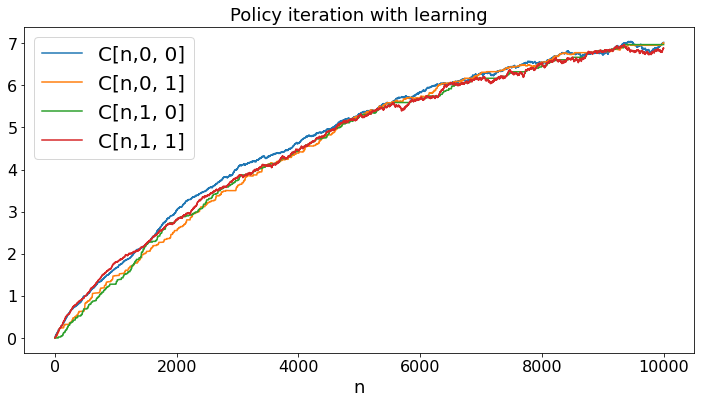

In [21]:
# Policy Iteration with Learning

N = 10000
delta = 0.02
case = 'PL'
C = np.zeros([N,dim,dim])
X = 0 # first item
Y = 0 # item in buffer

for n in range(N-1):
    Xp = discreteRV(P[X,:])
    C[n+1,:,:] = C[n,:,:]
    if C[n,Xp,Xp] < C[n,Xp,X]:
        Z = Xp
    else:
        Z = Y
    C[n+1,X,Y] = (1 - delta)*C[n,X,Y]+delta*(Xp != Y) + delta*rho*C[n,Xp,Z]   
    if np.random.binomial(1,0.5) == 1: # forced learning
        Y = Xp
    else:
        if C[n+1,Xp,Xp] < C[n+1,Xp,Y]:
            Y = Xp
    X = Xp

for i in range(dim):
    for j in range(dim):
        plt.plot(C[:,i,j],label = 'C[n,'+str(i)+', '+str(j)+']')
plt.title('Policy iteration with learning')
plt.xlabel('n')
plt.xticks(np.arange(N+1, step=int(N/5)))
plt.legend()
plt.show()

# Bandit Problem

We are given two coins $A$ and $B$.  One has a probability $0.55$ of tails, the other a probability $0.45$, but we don't know which is which: coin $A$ has probability of tails equal to $0.55$ with probability $0.5$.  The problem is to choose, at each step, which coin to flip in order to accumulate tails as fast as possible.  

If we knew which coin is the best, we would accumulate $0.55n$ tails in $n$ steps, on average.  Since we don't know, we will accumulate some average number $S(n)$ of tails after $n$ steps. One defines the **regret** $R(n) = 0.55n - S(n)$.  The goal is to desing a strategy that makes $R(n)$ small, as $n$ gets large.  

For instance, if we eventually settle on one of the two coins and if there is a probability $p$ that we settle on the wrong coin, then $R(n)$ grows like $p \times 0.1n$ for $n$ large.
One can show that no strategy exists with $R(n)$ smaller than $O(\log(n)$.  Also, a simple stragey achieves that rate of growth of the regret.  That strategy is **Thompson sampling**.  It is defined as follows.  At step $n$, the Thompson strategy flips coin $A$ with the probability that it is the best coin given the past coin flips.  This is a remarkable result because discovering the probability that coin $A$ is the best depends on the fraction of time that we flip it.  The cell below simulates the Thompson sampling.

In [22]:
def dummy(Nd):
    global N
    N = int(Nd)
    
Nd = widgets.Dropdown(options=['100', '200', '500','1000','2000','3000','4000','5000'],value='1000',description='N',disabled=False)
z = widgets.interactive(dummy,Nd=Nd) 
display(z) 

interactive(children=(Dropdown(description='N', index=3, options=('100', '200', '500', '1000', '2000', '3000',…

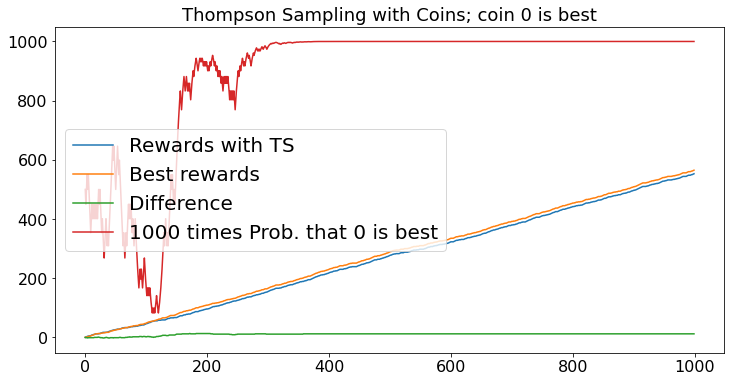

If you want to try another value of N, 
 go back to widgets above, select, and rerun this cell


In [23]:
matplotlib.rcParams.update(params)
# Thompson Sampling
# p(m,n,M,N) = P(coin 0 is best given
# m '0s' out on M with a=0 and n '0s' out of N with a=1
# Bayes' Rule gives p(m,n,M,N)) = 1/(1 + Q(m,n,M,N))
# where Q(m,n,M,N) = (0.55/0.45)**(2(m-n)+ N - M)
# Thus, Q is multiplied by 0.55/0.45 
#     when M += 1 and m += 1 and N += 1 and n += 0
# and Q is divided by 0.55/0.45 
#.  when M += 1 and m += 0 and N += 1 and n += 1
# Let U be the next action and Y the next outcome:
#    if U == Y: Q = Q*0.55/0.45, else, Q = Q*0.45/0.55
         
def TS(N):
    U = np.zeros(N)
    Y = np.zeros(N)
    R = np.zeros(N) # accumulated rewards
    B = np.zeros(N) # best rewards
    LOG = [np.log(1+n) for n in range(N)]
    P = np.zeros(N)
    Q = 1
    P[0] = 0.5
    C = [0.45, 0.55] # coin 1 is best
    if np.random.binomial(1,0.5):
        C = [0.55, 0.45] # coin 0 is best
    for n in range(N-1):
        P[n] = 1/(1+Q)
        U[n] = np.random.binomial(1,1 - P[n]) # choose coin
        # if P[n] << 1, U[n] is likely to be 1 because coin 0
        # is unlikely to be best
        if U[n] == 0:
            coin = C[0]
        else:
            coin = C[1]
        Y[n] = np.random.binomial(1,coin)
        R[n+1] = R[n] + Y[n]
        if coin == 0.55:
            B[n+1] = B[n] + Y[n]
        else:
            B[n+1] = B[n] + np.random.binomial(1,0.55)
        if Y[n] == U[n]:
            Q = Q*0.55/0.45
        else:
            Q = Q*0.45/0.55    
        P[n+1] = 1/(1+Q)
    W = ''
    if C[0] == 0.55:
        W = '; coin 0 is best'
    else:
        W = '; coin 1 is best'

    plt.plot(R,label='Rewards with TS')
    plt.plot(B,label='Best rewards')
    plt.plot(B-R,label='Difference')
    plt.plot(N*P,label=str(N) +' times Prob. that 0 is best')
    plt.legend()
    plt.title('Thompson Sampling with Coins' + W)
    plt.show()
   
TS(N)   
print('If you want to try another value of N, \n go back to widgets above, select, and rerun this cell')

# Exercise on Control

Consider the caching problem

* Assume the buffer can store two items
* There are 5 types of items with the following transition matrix:

![title](Figures/requests.pdf)

* What is the state?
* How many states are there?
* What are the possible actions?
* How many actions are possible in each state?
* How many possible strategies are there?
* Write the dynamic programming equations
* Solve them by using value iteration
* Plot the minimum expected cost to go from a state that you choose as a function of the iteration step in the value iteration algorithm.